본 내용은 올 1월에 교육용으로 준비했던 자료입니다. 데이터를 통해 어떻게 미래 동향을 파악할 수 있는지 확인하고, 현재의 비트코인 가격과 비교해 보시면 좋겠습니다. 예측 결과는 실제 결과와 매우 상이할 것입니다. 과거 데이터만으로 미래를 예측하는 것의 한계를 시사합니다.

> TOC
```
Step 1. 데이터 전처리
Step 2. 이동평균과 단순 지수평활
     2-1. 일별 비트코인 가격
     2-2. 일별 비트코인 가격의 이동평균
     2-3. 일별 비트코인 가격의 단순 지수평활
     2-4. 이동평균과 단순 지수평활의 비교
Step 3. 추세와 계절성을 추가한 2차, 3차 지수평활
     3-1. 2차 지수평활
     3-2. 3차 지수평활
Step 4. (결론) 비트코인 가격 전망
```

## Step 1. 데이터 전처리

데이터는 2016년 12월 8일부터 2022년 1월 8일까지의 비트코인 일별 종가를 사용합니다. 저는 미리 확보해둔 데이터를 사용했지만, 꼭 동일한 데이터로 실습할 필요는 없습니다. 웹에 공개된 데이터가 많으니 비트코인이든 주가 데이터든 직접 스크래핑이나 다운로드 방식으로 데이터 확보를 해보시면 좋겠습니다.

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use(['seaborn'])

import warnings
warnings.filterwarnings(action='ignore')

from statsmodels.tsa.api import SimpleExpSmoothing, ExponentialSmoothing

In [39]:
df_raw = pd.read_csv('./data/bitcoin.csv', thousands=',')
df_raw.tail()

,날짜,종가,오픈,고가,저가,거래량,변동 %
1853,2016년 12월 12일,778.5,767.9,781.3,767.9,28.76K,1.38%
1854,2016년 12월 11일,767.9,774.0,774.2,763.0,17.14K,-0.79%
1855,2016년 12월 10일,774.0,770.5,777.0,769.2,18.02K,0.46%
1856,2016년 12월 09일,770.5,768.5,773.5,765.0,24.18K,0.26%
1857,2016년 12월 08일,768.5,765.6,773.4,761.2,28.78K,0.38%


여기서 종가 데이터만 가져오고 날짜의 경우 datetime 타입으로 변환한 다음 인덱스로 지정해 줍니다. datetime을 인덱스로 두게 되면 데이터 프레임이 기본적으로 시계열 데이터로 간주되어 인덱싱을 더 편하게 할 수 있습니다.

In [40]:
df = df_raw[['종가']].astype('float64')
df.index = pd.to_datetime(df_raw['날짜'], format="%Y년 %m월 %d일")
df.columns = ['close']
df.index.name = 'date'
df.sort_index(inplace=True)
df

,close
date,
2016-12-08,768.5
2016-12-09,770.5
2016-12-10,774.0
2016-12-11,767.9
2016-12-12,778.5
...,...
2022-01-04,45837.3
2022-01-05,43425.9
2022-01-06,43097.5


In [44]:
df.index

DatetimeIndex(['2016-12-08', '2016-12-09', '2016-12-10', '2016-12-11',
               '2016-12-12', '2016-12-13', '2016-12-14', '2016-12-15',
               '2016-12-16', '2016-12-17',
               ...
               '2021-12-30', '2021-12-31', '2022-01-01', '2022-01-02',
               '2022-01-03', '2022-01-04', '2022-01-05', '2022-01-06',
               '2022-01-07', '2022-01-08'],
              dtype='datetime64[ns]', name='date', length=1858, freq='D')

In [45]:
df.index.freq='D'
df.index

DatetimeIndex(['2016-12-08', '2016-12-09', '2016-12-10', '2016-12-11',
               '2016-12-12', '2016-12-13', '2016-12-14', '2016-12-15',
               '2016-12-16', '2016-12-17',
               ...
               '2021-12-30', '2021-12-31', '2022-01-01', '2022-01-02',
               '2022-01-03', '2022-01-04', '2022-01-05', '2022-01-06',
               '2022-01-07', '2022-01-08'],
              dtype='datetime64[ns]', name='date', length=1858, freq='D')

## Step 2. 이동평균과 단순 지수 평활

### 2-1. 일별 비트코인 가격

먼저, 가볍게 단순 종가('Close')부터 그려봅니다.

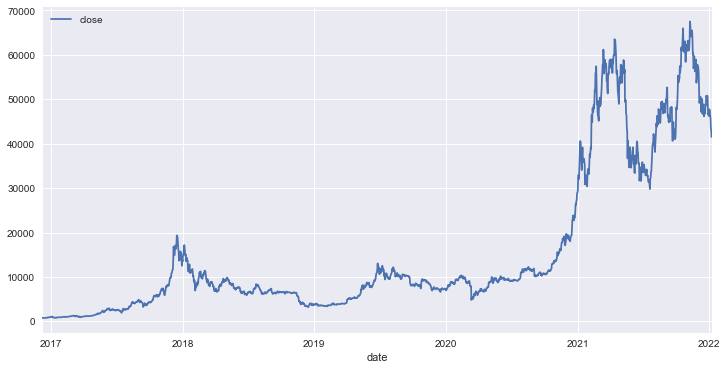

In [46]:
df.plot(figsize=(12,6));

### 2-2. 일별 비트코인 가격의 이동 평균

이동평균은 시계열 형태의 데이터 프레임에서 제공하는 rolling() 함수를 사용해 구할 수 있습니다. rolling() 함수를 사용하면 아래와 같이 mean() 뿐만 아니라 std(), min(), max() 등 다양한 통계 함수로 원하는 집계를 수행할 수 있습니다.

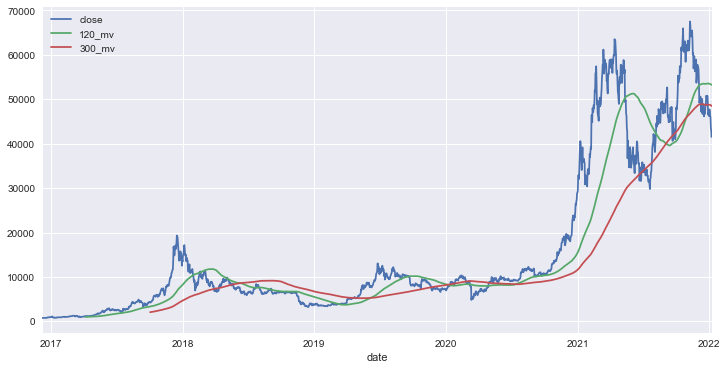

In [47]:
df['120_mv'] = df['close'].rolling(window=120).mean()
df['300_mv'] = df['close'].rolling(window=300).mean()
df.plot(figsize=(12,6));

### 2-3. 일별 비트코인 가격의 단순 지수 평활

이동평균선은 기본적으로 예측을 위한 지표는 아닙니다. 단순히 과거의 데이터를 기간별로 평균 낸 수치로, 가격의 흐름에 따라서 움직이는 후행지표입니다. 그래서 가격 정보가 아직 없는 미래에 대해 이동평균선을 그려보면 추세를 따라 올라갈 것 같지만 가격이 존재했던 과거 기점을 마지막으로 값은 고정됩니다. 추세에 대한 정보 역시 포함하지 않기 때문입니다.

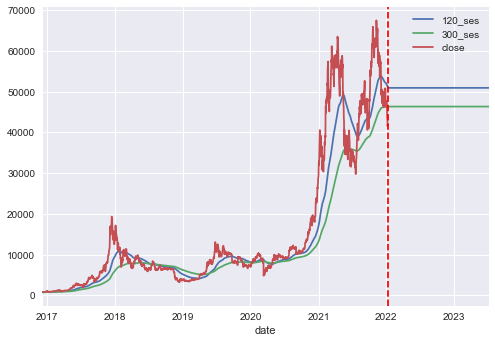

In [58]:
span = 120 # the period of moving average
ses = SimpleExpSmoothing(df['close'])
ses = ses.fit(smoothing_level=2/(span+1), optimized=False)
ses.predict(start=0, end=2400).plot(label='120_ses')
ses = ses.fittedvalues.shift(-1)
df['120_ses'] = ses

span = 300
ses = SimpleExpSmoothing(df['close'])
ses = ses.fit(smoothing_level=2/(span+1), optimized=False)
ses.predict(start=0, end=2400).plot(label='300_ses')
ses = ses.fittedvalues.shift(-1)
df['300_ses'] = ses

df['close'].plot(label='close')

plt.legend()
plt.axvline(df.index[-1], c='r', linestyle='--')

plt.show()

위 그래프는 이동평균은 아니지만 120일 이동평균, 300일 이동평균선에 지수의 움직임을 더 잘 반영할 수 있도록 가중 평균한 값을 그리고 있습니다. 이것을 단순 지수 평활 혹은 1차 지수 평활이라고 하는데, 단순하게 최근에 가까울수록 지수를 더 잘 반영하는 조정된 이동평균선이라 생각하면 되겠습니다. 단순 지수 평활은 statsmodels 라이브러리의 SimpleExpSmoothing 함수를 사용하면 위와 같이 간단히 그릴 수 있습니다. 함수를 통해 인스턴스(ses 변수에 담았습니다)를 생성하고 모델을 fitting 하는 과정을 보여주고 있습니다.​

이렇게 구현한 단순 지수 평활 역시 '이동평균' 방식을 취한다는 점에서 보다시피 미래에 대한 예측은 어렵습니다. 기술적으로 과거에 대한 정보만 담기 때문입니다. 그래서 이동평균과 1차 지수 평활은 미래에 대한 예측보다는 살까 팔까에 대한 심리적 저항선 정도로 사용하는 것이 일반적입니다. 

그래서 사실 이 이동평균선을 단기적으로 뚫고 지나가거나 한참 위를 웃돈다 하더라도 결국 장기적으로는 전혀 이상한 일이 아닙니다만, 많은 투자자들이 이동평균선을 매매 지표로 활용하는 만큼 장기 이동평균선의 바닥을 찍었을 때 매수세가 강하게 들어와서 주가가 다시 튀어 오르는 경우가 많기 때문에 단순 심리적 저항선 이상의 의미를 지니기도 합니다.

### 2-4. 이동평균과 단순 지수 평활의 비교

이동평균과 지수 평활 그래프를 잠시 비교해 보면, 아래 그래프에서 120일 지수 평활(120_ses, *ses : simple exponential smoothing), 300일 지수 평활(300_ses) 선은 각각 120일 이동평균(120_mv), 300일 이동평균(300_mv) 선보다 실제 지수를 더 잘 반영하고 있음을 알 수 있습니다.

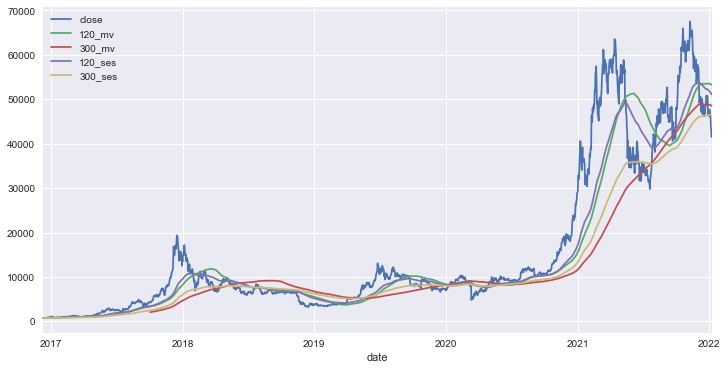

In [49]:
df.plot(figsize=(12,6));

2021년 그래프만 확대해 보면 다음과 같습니다.

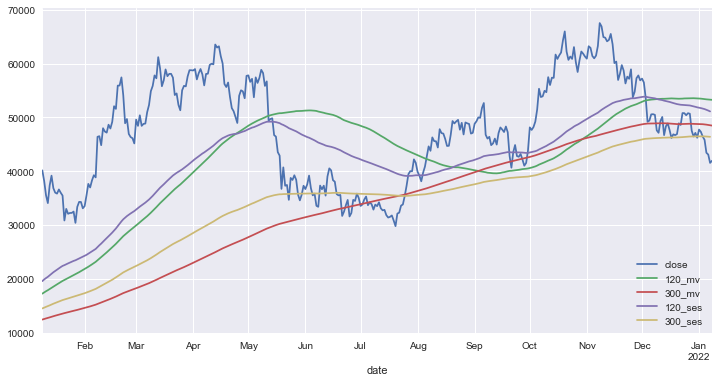

In [50]:
df.iloc[-365:].plot(figsize=(12,6));

초록색 선(120일 이동평균, 120_mv)은 보라색 선(120일 지수 평활_120_ ses)보다 하락장을 잘 반영하지 못하는 모습을 보입니다. 붉은색 선(300일 이동평균, 300_mv)과 노란색 선(300일 지수 평활, 300_ses)을 봐도 그렇습니다. 이는 누적된 과거 데이터가 단기간 지수의 상승과 하락을 기민하게 따라갈 수 없도록 하기 때문입니다. 그래서 최근 데이터에 가중치를 주는 지수 평활법이 이동평균법보다 현재 가격의 모습을 더 잘 반영하게 됩니다.

하지만 앞서 설명했듯 1차 지수 평활법으로도 여전히 미래를 설명할 수 없습니다. 시계열 데이터에는 가격과 같은 단순 1차원 정보뿐만 아니라 단기 혹은 장기적 추세, 추세 주위를 오르내리는 사이클, 그리고 추세와는 별도로 특정 주기로 움직이는 계절성 등이 담겨있습니다. 그래서 2차 지수 평활, 3차 지수 평활법을 통해 추세나 계절성을 반영해서 앞으로의 주가 움직임을 예측하려는 시도가 있었습니다.

## Step 3. 추세와 계절성을 추가한 2차, 3차 지수 평활​

### 3-1. 2차 지수 평활

1차 지수 평활에 추세를 더한 것이 2차 지수 평활, 2차 지수 평활에 계절성까지 더한 것이 3차 지수 평활입니다. 먼저 2차 지수 평활부터 보면, 2022년 이후 데이터가 없음에도 불구하고 1차 지수 평활과 달리 약간의 상승하는 움직임을 보여주고 있습니다. 과거 데이터가 그간 상승 추세에 있음을 고려하여 앞으로의 움직임을 '상승'으로 표현하고 있는 것입니다.

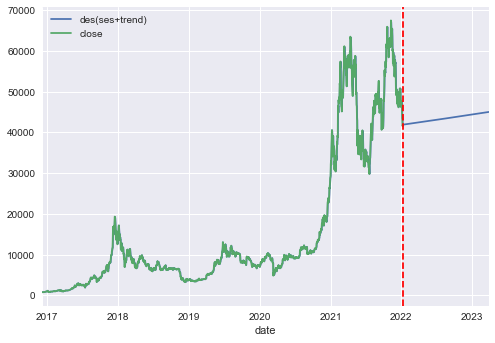

In [59]:
des = ExponentialSmoothing(df['close'], trend='mul')
des = des.fit()
des.predict(start=0, end=2300).plot(label='des(ses+trend)')
des = des.fittedvalues
df['des'] = des

df['close'].plot(label='close')

plt.axvline(df.index[-1], c='r', linestyle='--')

plt.legend()
plt.show()

### 3-2. 3차 지수 평활

여기에 계절성까지 더한 3차 지수 평활은 어떨까요? 계절성의 경우 추세와 별도로 등락의 움직임이 특정 주기로 나타나는 것을 의미하는데, 주가나 암호화폐 가격의 경우 계절성이 선명하게 나타나지 않습니다. 

오션월드 매출 그래프를 상상해 보면 여름에 폭발적으로 증가하고 겨울에는 바닥을 치고 있을 것이나 비트코인은 그렇지 않습니다. 1년 단위로 보면 항상 오르는 방향으로 가지만 분기에 따라서 내림세를 겪기도 하기 때문에 추세와 계절성이 복합적으로 얽혀있습니다. 물론 이외에도 우리가 가늠할 수 없는 수많은 외생변수들도 포함되어 있을 것이다. 따라서 여기서는 1분기(1q), 2분기(2q), 1년(1y) 주기의 계절성이 있다고 가정하고 그려볼 것입니다. 



In [79]:
tes = ExponentialSmoothing(df['close'], trend='mul', seasonal='mul', seasonal_periods=90)
tes = tes.fit()
tes.predict(start=0,end=1900)

2016-12-08      772.173691
2016-12-09      774.399279
2016-12-10      777.755476
2016-12-11      771.433485
2016-12-12      781.892956
                  ...     
2022-02-16    20116.054700
2022-02-17    19553.341477
2022-02-18    19390.183023
2022-02-19    19051.954237
2022-02-20    18784.826073
Freq: D, Length: 1901, dtype: float64

/Users/swsong/opt/anaconda3/envs/dataScience/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


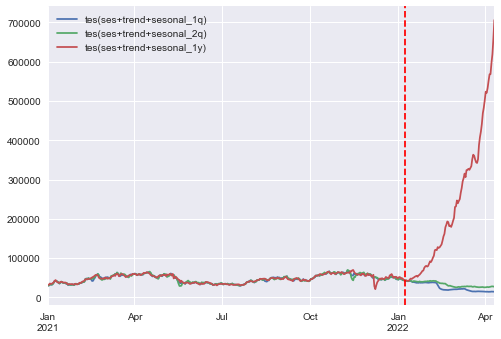

In [87]:
tes = ExponentialSmoothing(df['close'], trend='mul', seasonal='mul', seasonal_periods=90)
tes = tes.fit()
tes.predict(start=0, end=1950)["2021":].plot(label='tes(ses+trend+sesonal_1q)')
tes = tes.fittedvalues
df['1q_tes'] = tes

tes = ExponentialSmoothing(df['close'], trend='mul', seasonal='mul', seasonal_periods=180)
tes = tes.fit()
tes.predict(start=0, end=1950)["2021":].plot(label='tes(ses+trend+sesonal_2q)')
tes = tes.fittedvalues
df['2q_tes'] = tes

tes = ExponentialSmoothing(df['close'], trend='mul', seasonal='mul', seasonal_periods=365)
tes = tes.fit()
tes.predict(start=0, end=1950)["2021":].plot(label='tes(ses+trend+sesonal_1y)')
tes = tes.fittedvalues
df['1y_tes'] = tes

plt.axvline(df.index[-1], c='r', linestyle='--')

plt.legend()
plt.show()

계절성이 1년 주기로 나타난다고 가정했을 때(붉은색) 2022년 이후 급격한 상승세를 보입니다. 반대로 계절성이 분기 혹은 반기 단위로 나타난다고 가정했을 때(파란색, 초록색) 약간의 조정 혹은 하락세를 보입니다. 해석하자면 붉은색 선의 경우 1년 단위로 상승하는 성향에 더해 최근 2021년에 급상승한 추세를 고려해서 2022년은 더 가파른 상승장이 나타난다고 예측했으며 파란색, 초록색 선의 경우 분기나 반기로는 하락하는 구간이 상대적으로 잦았기에 추세를 거스르는 하락장을 예측한 것입니다.

## Step 4. 비트코인 가격 전망

이렇게 지금까지 대중적으로 잘 알려진 이동평균부터, 간단하지만 시계열 예측 이론의 핵심을 담고 있는 2차, 3차 지수 평활법까지 살펴보았습니다. 이를 통해 비트코인 가격을 전망해 보면, 전체 기간으로 보면 상승해왔고 여전히 상승 추세에 있다고 볼 수 있으며 이 추세가 계속 간다고 하면 1년 내에 10억까지도 갈 수 있습니다. 그러나 추세를 꺾을만한 변동성이 나온다면 하락세에 접어들 수 있습니다. 

시계열 예측이 명확한 답을 내놓지 못하고 확률적으로 해석할 수밖에 없는 이유, 그리고 주가나 암호화폐 가격의 예측이 어려운 이유는 하루가 지나면 새로운 가격 정보와 새로운 외생 변수들이 생겨나기 때문입니다. 이번 분석 역시 마찬가지로 2022년 다음 한 분기를 전망해 보았지만 시간이 흐르면서 새로운 정보가 추가될 것이고 가격의 움직임과 계절성, 추세 등의 변화에 따라 예측은 달라지게 되어있습니다. 

따라서 경제뉴스, 각종 시장 동향 리포트 등 시간을 기준으로 하는 모든 예측 분석은 "현재까지 데이터로 보면 이렇고, 앞으로는 달라질 여지가 충분하다"라고 이해하는 것이 바람직하겠습니다.